In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import uszipcode
from uszipcode import SearchEngine
import gc
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree

import fredapi as fa

In [2]:
df_car = pd.read_csv('used_cars_data.csv', usecols=['make_name','model_name','year','mileage','listing_color','price'])

In [3]:
#df_car = df_car[['make_name','model_name','year','mileage','listing_color','price']]

In [4]:
df_car.head()

,listing_color,make_name,mileage,model_name,price,year
0,YELLOW,Jeep,7.0,Renegade,23141.0,2019
1,BLACK,Land Rover,8.0,Discovery Sport,46500.0,2020
2,UNKNOWN,Subaru,NaN,WRX STI,46995.0,2016
3,GRAY,Land Rover,11.0,Discovery,67430.0,2020
4,BLACK,Land Rover,7.0,Discovery Sport,48880.0,2020


## Data Prep

In [5]:
#replace empty values with NaN
df_car = df_car.replace(r'^\s*$', np.nan, regex=True)

In [6]:
df_car.columns

Index(['listing_color', 'make_name', 'mileage', 'model_name', 'price', 'year'], dtype='object')

In [7]:
#Because of memory issues, need to cut down on categorical values
#For models, I'll keep the ones with a count of at least 10k, the rest will be other. This represents about 2/3 
top_10k_models = df_car.model_name.value_counts()[df_car.model_name.value_counts()>=10000].index.tolist()
df_car['model_name'] = df_car['model_name'].apply(lambda x: 'other' if x not in top_10k_models else x)

In [8]:
#Similarly, will select makers with a count of over 8k, below that seems like there are more rare and luxury cars
top_8k_makers = df_car.make_name.value_counts()[df_car.make_name.value_counts()>=8000].index.tolist()
df_car['make_name'] = df_car['make_name'].apply(lambda x: 'other' if x not in top_8k_makers else x)

In [9]:
#Remaining nulls are in categorical values, will drop them since imputing is not helpful and there aren't that many of them
#Lose 250k rows, but we still have 2.75mm. Good enough
df_car.dropna(inplace=True)

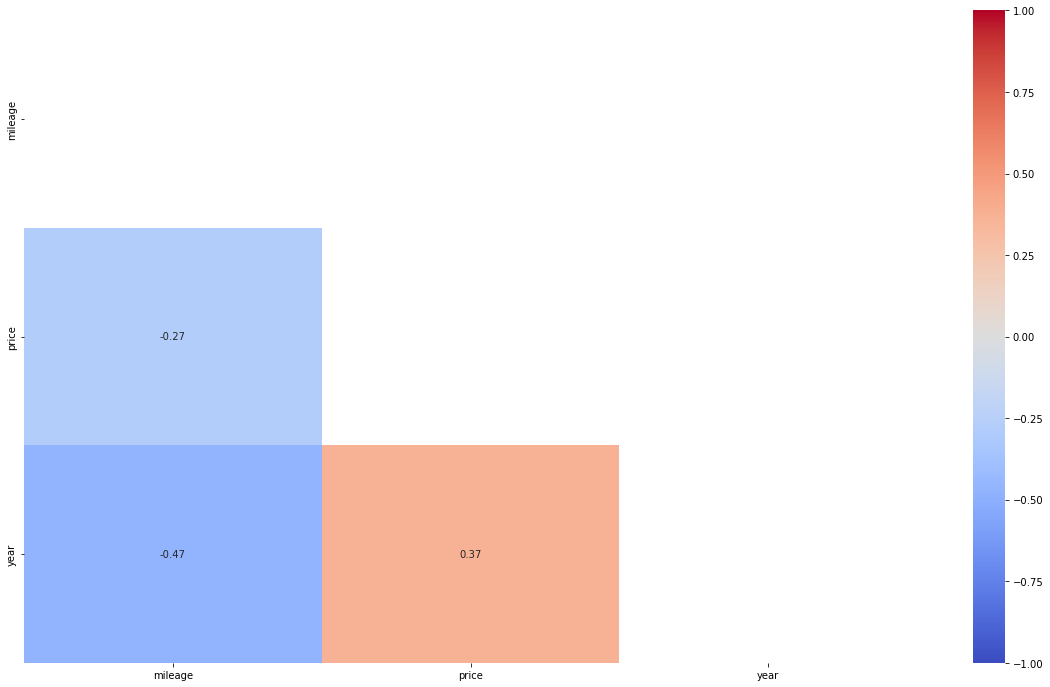

In [10]:
plt.figure(figsize=(20,12))
mask = np.triu(np.ones_like(df_car.corr(), dtype= bool))
sns.heatmap(df_car.corr(), annot=True, cmap='coolwarm', mask=mask,vmin=-1, vmax=1);

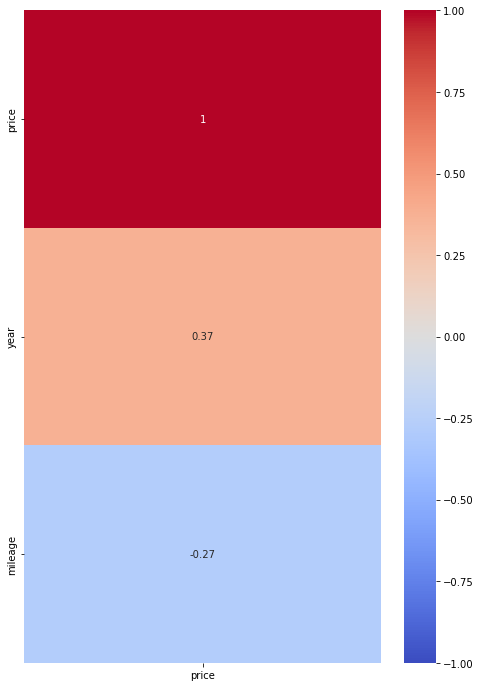

In [11]:
plt.figure(figsize=(8, 12))
sns.heatmap(df_car.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm');

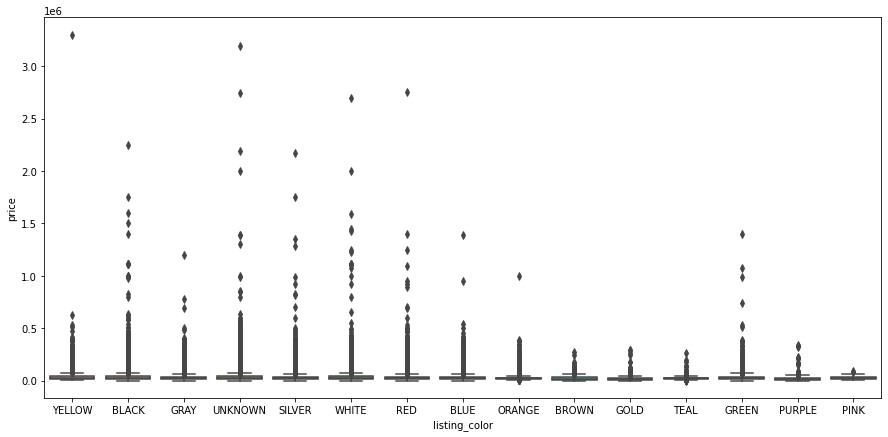

In [12]:
plt.figure(figsize=(15,7))
sns.boxplot(y='price', x='listing_color', data=df_car);

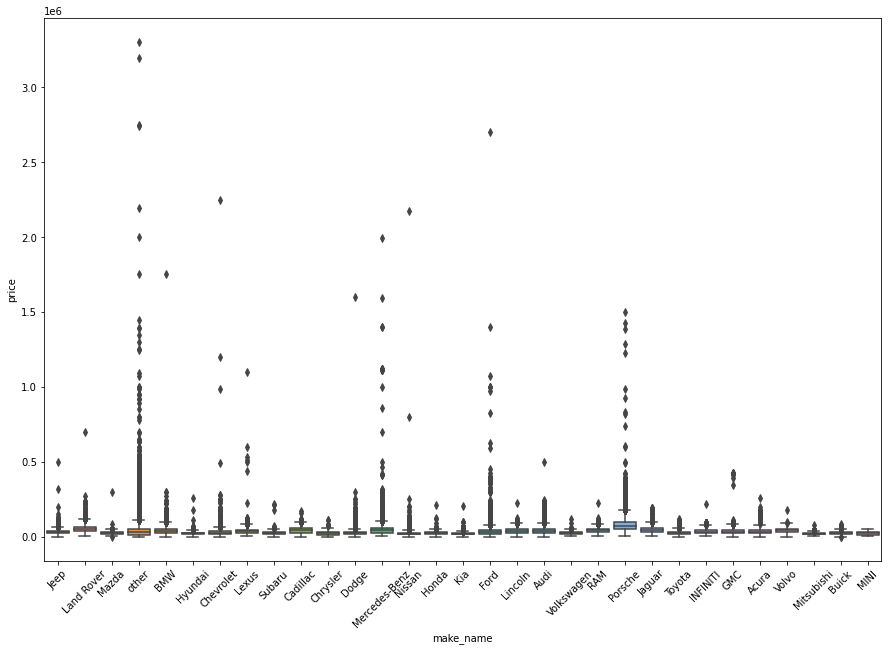

In [13]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(y='price', x='make_name', data=df_car);

In [14]:
cols_numeric = df_car.select_dtypes(include=np.number).columns.tolist()

In [15]:
#limit data to these models and makes
df_car = df_car[df_car['model_name']!='other']

## Z Score outlier removal

In [16]:
idx = np.all(stats.zscore(df_car.select_dtypes(include=np.number)) < 3, axis=1)
df_final_clean = pd.concat([df_car.select_dtypes(include=np.number).loc[idx], 
                            df_car.select_dtypes(exclude=np.number).loc[idx]], axis=1)

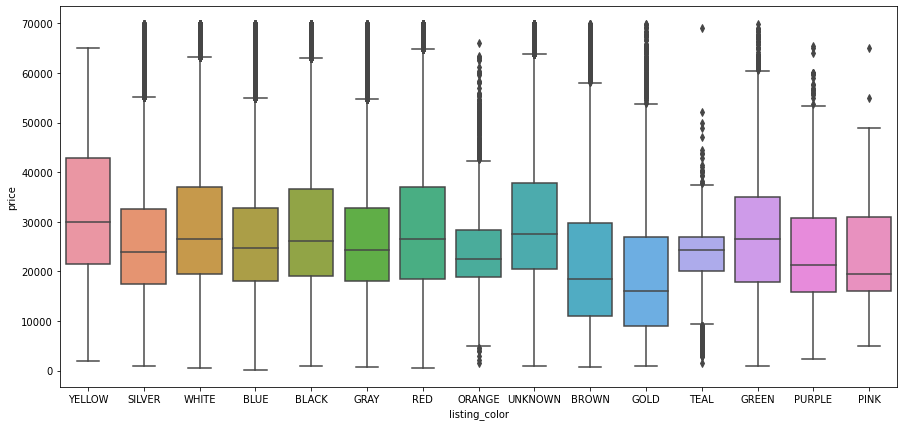

In [17]:
plt.figure(figsize=(15,7))
sns.boxplot(y='price', x='listing_color', data=df_final_clean);

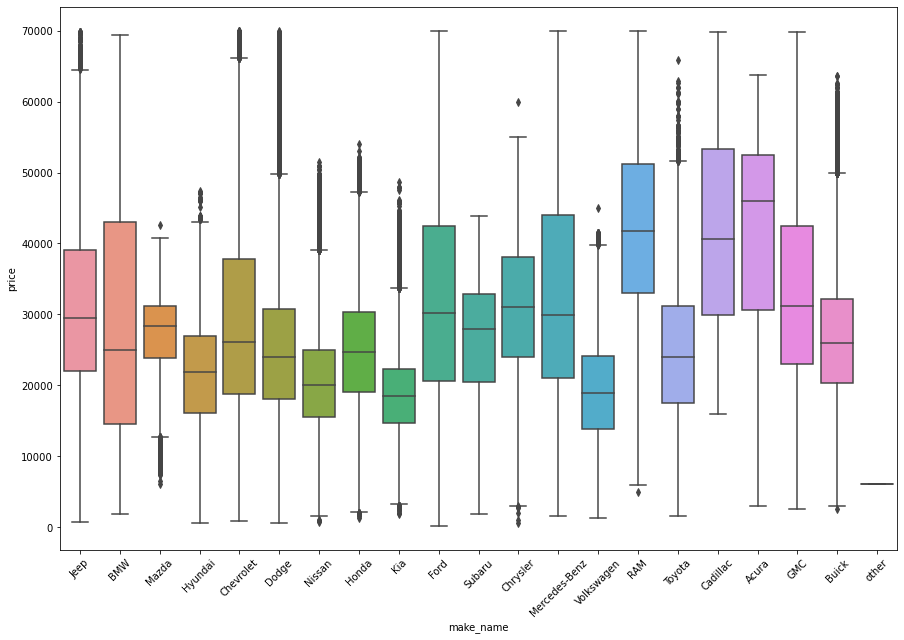

In [18]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(y='price', x='make_name', data=df_final_clean);

In [19]:
#del(df_car)
#del(df_na_lookup)
#del(df_car_final)
#gc.collect()

In [35]:
df_final_clean.groupby(['listing_color']).sum().index#.reset_index()

Index(['BLACK', 'BLUE', 'BROWN', 'GOLD', 'GRAY', 'GREEN', 'ORANGE', 'PINK',
       'PURPLE', 'RED', 'SILVER', 'TEAL', 'UNKNOWN', 'WHITE', 'YELLOW'],
      dtype='object', name='listing_color')

## Model

In [21]:
df_model = pd.get_dummies(df_final_clean)

In [22]:
df_model.shape

(1908965, 124)

In [23]:
X = df_model.drop('price', axis=1)
Y = df_model['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Random Forest

In [ ]:
params = {
    'max_features' : ['sqrt','log2','auto'],
    'max_depth' : [30,75,100, None],
    'n_estimators': [100, 150],
    'criterion': ["squared_error", "absolute_error"],
    'bootstrap': [True],
    'oob_score': [True, False]
}

gs_dt = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=params,
    cv=3,
    verbose=1
)

gs_dt.fit(X_train,y_train)
print(gs_dt.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [31]:
for i in range(150,400,25):
    print(i)
    rf = RandomForestRegressor(n_estimators=10, max_depth=77, min_samples_split=i, max_features=69)
    rf.fit(X_train,y_train)
    print('training data accuracy')
    print(r2_score(y_train,rf.predict(X_train)))
    rf_y_pred = rf.predict(X_test)
    print('test data accuracy')
    print(r2_score(y_test,rf_y_pred))
    print('rmse')
    print(np.sqrt(mean_squared_error(y_test,rf_y_pred)))

150
training data accuracy
0.8740198691816021
test data accuracy
0.8687133521496865
rmse
4606.5918187600455
175
training data accuracy
0.8734548972133621
test data accuracy
0.8687841622235267
rmse
4605.349357673965
200
training data accuracy
0.8730386689111893
test data accuracy
0.8687111778640279
rmse
4606.62996431872
225
training data accuracy
0.872715504429407
test data accuracy
0.8687074429174988
rmse
4606.695489296209
250
training data accuracy
0.8723737955970704
test data accuracy
0.8685947476970028
rmse
4608.672148214819
275
training data accuracy
0.8720054057264188
test data accuracy
0.868527748998328
rmse
4609.846894592587
300


KeyboardInterrupt: 

In [24]:
rf = RandomForestRegressor(n_estimators=200, max_depth=77, min_samples_split=175, max_features=69)

In [25]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=77, max_features=69, min_samples_split=175,
                      n_estimators=200)

In [26]:
r2_score(y_train,rf.predict(X_train))

0.8737661541681894

In [27]:
rf_y_pred = rf.predict(X_test)

In [28]:
#R^2 for test data
r2_score(y_test,rf_y_pred)

0.8696783876051459

In [29]:
#RMSE
print(np.sqrt(mean_squared_error(y_test,rf_y_pred)))

4586.913476271618


In [30]:
cv = KFold(n_splits=5, shuffle=True)

In [31]:
scores = cross_val_score(rf, X, Y, scoring='neg_mean_squared_error', cv=cv)

In [32]:
np.sqrt(abs(scores))

array([4572.64423946, 4581.45003546, 4597.12291272, 4586.6753277 ,
       4601.53579245])

In [33]:
feat_importances = pd.Series(rf.feature_importances_, index=df_model.drop('price', axis=1).columns)

/home/diegofvargas/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


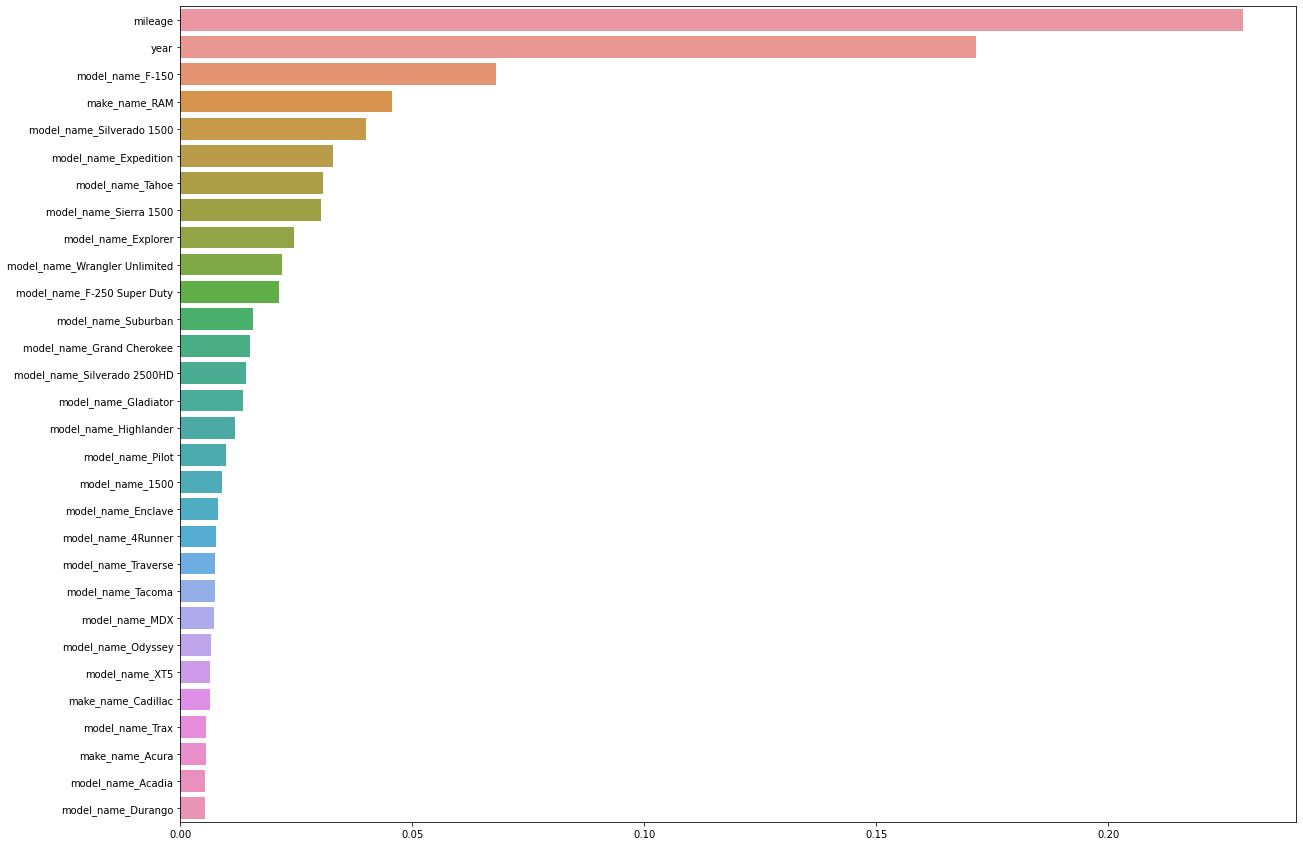

In [34]:
plt.figure(figsize=(20,15))
sns.barplot(feat_importances.sort_values(ascending=False).nlargest(30).values,
            feat_importances.sort_values(ascending=False).nlargest(30).index, orient='h');

<Figure size 432x288 with 0 Axes>

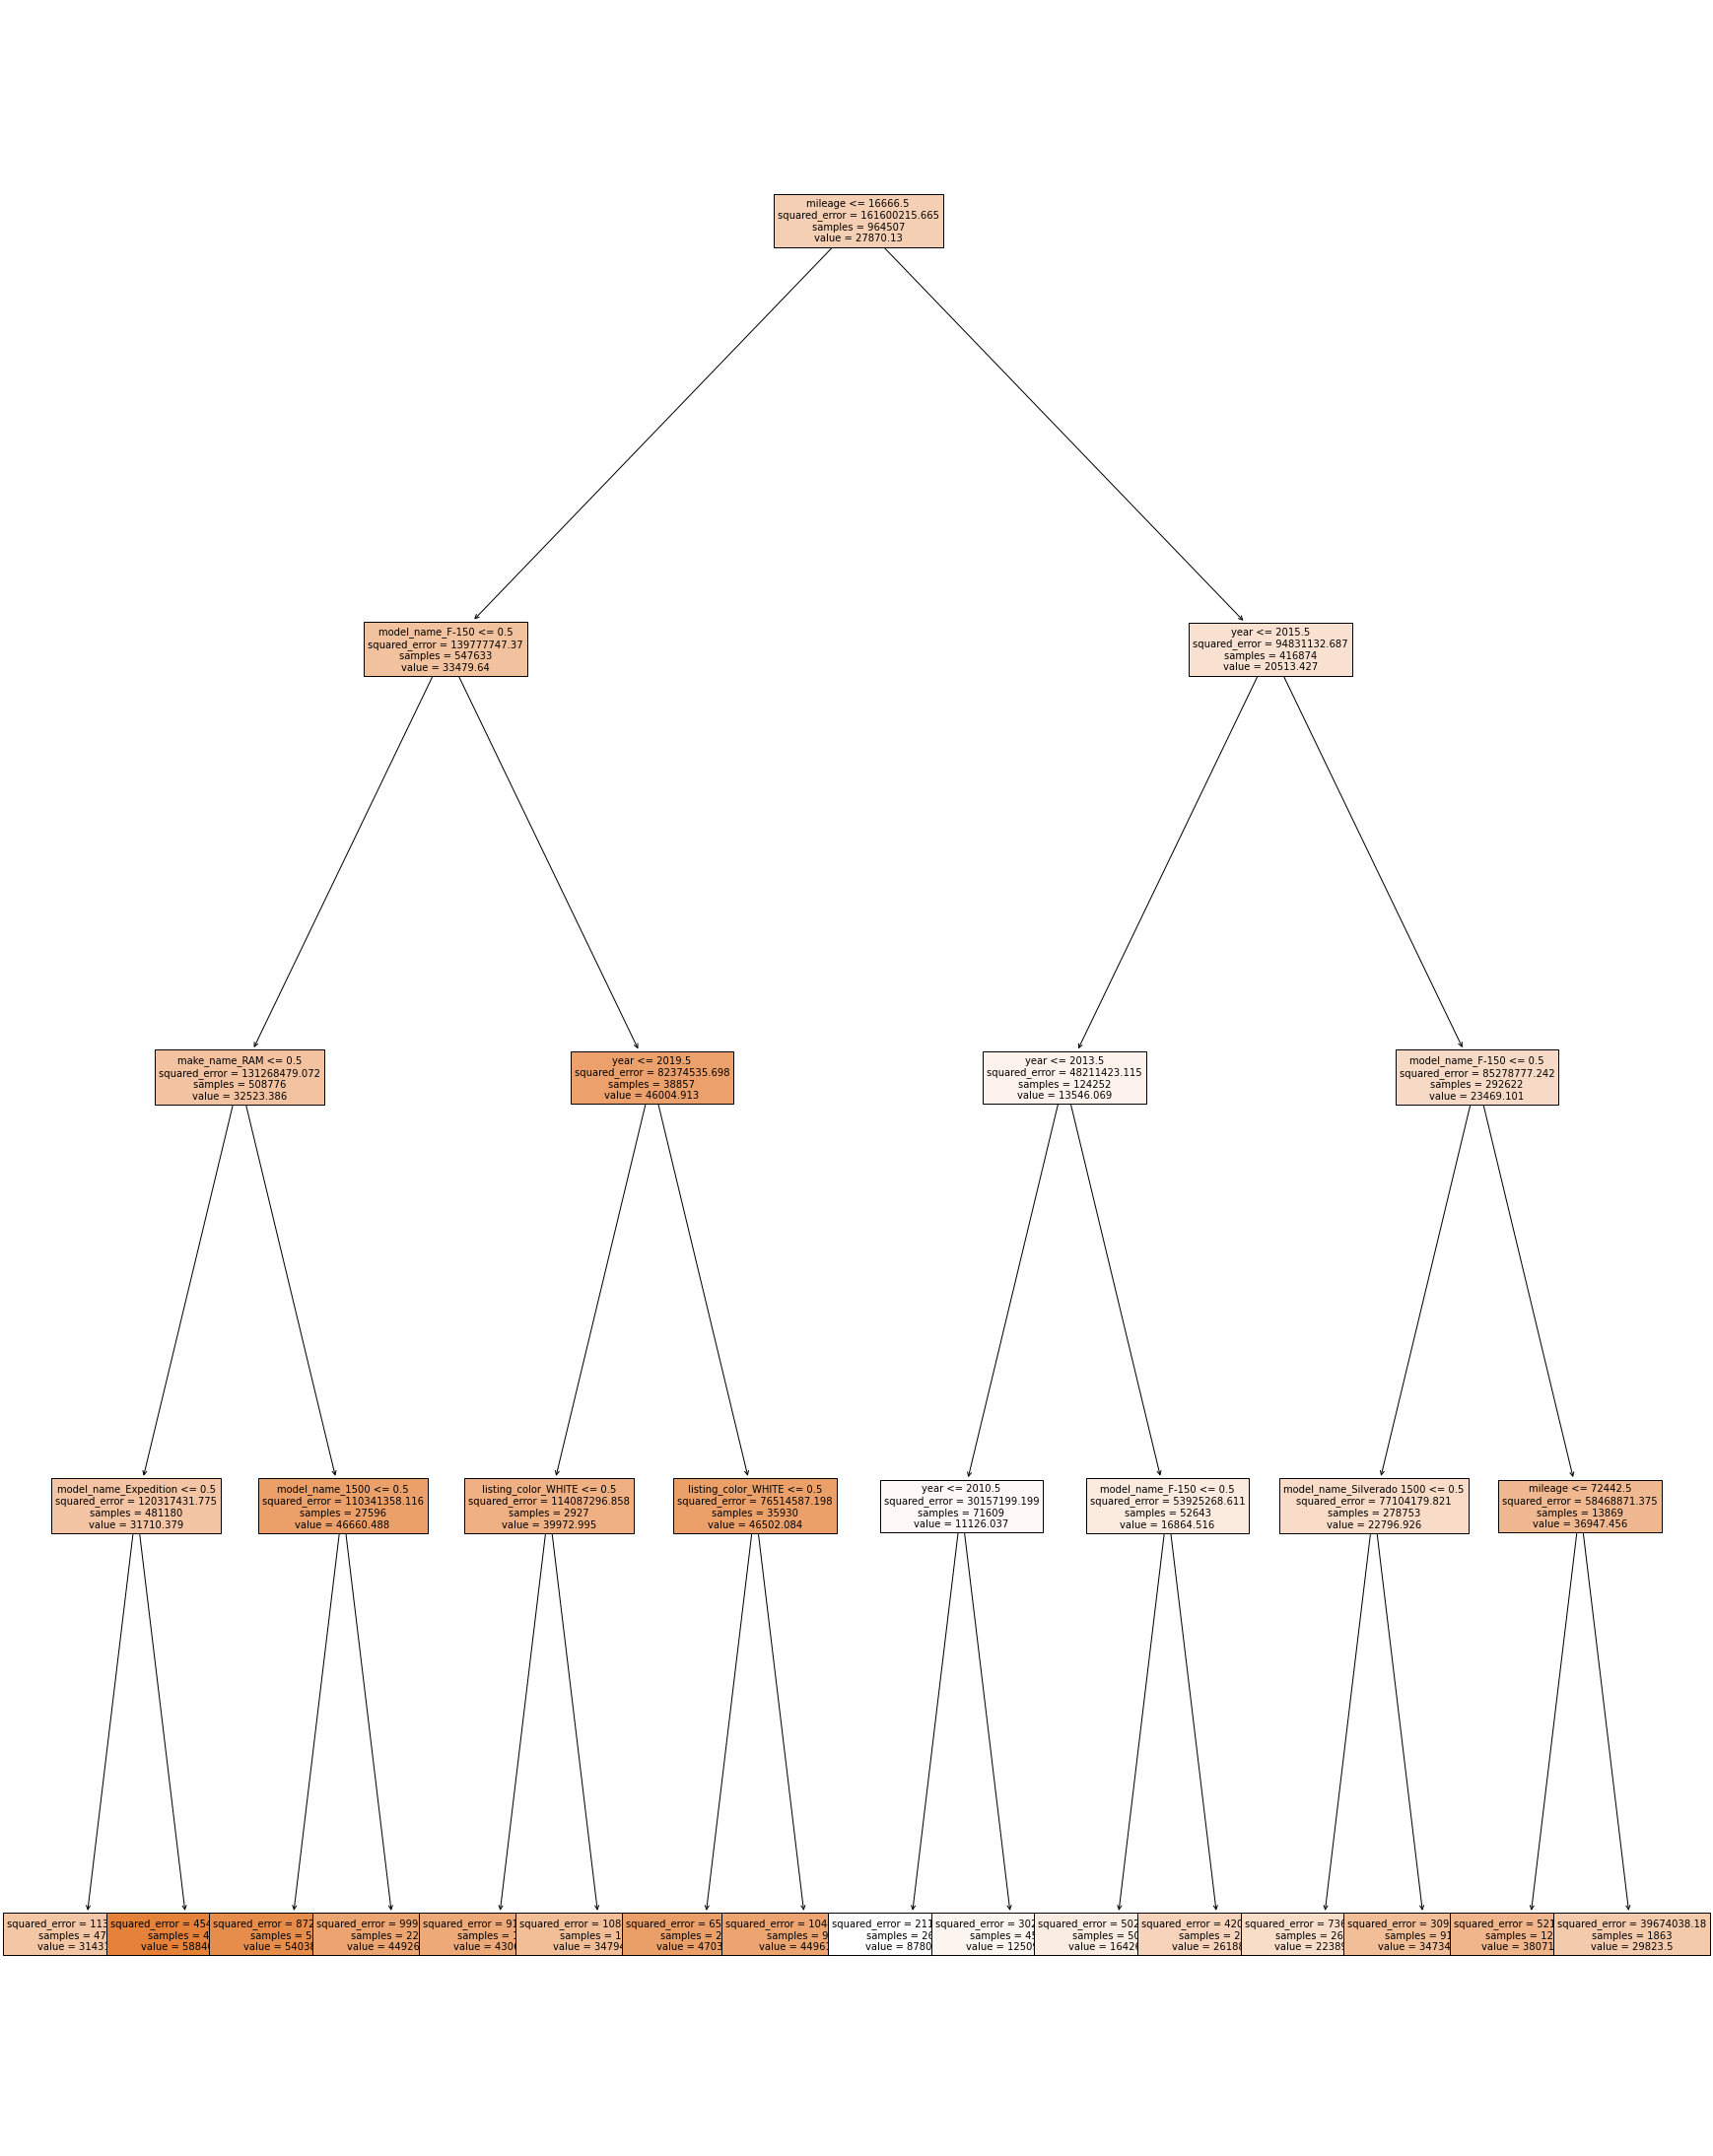

In [57]:
plt.figure()
plt.figure(figsize=(30,40))
tree.plot_tree(rf.estimators_[0], filled=True, fontsize=10, feature_names=X.columns)
plt.savefig('tree.png',format='png',bbox_inches = "tight")

In [35]:
import joblib
joblib.dump(rf, 'randomfs.pkl')
print("Random Forest Model Saved")

Random Forest Model Saved
